# Visualize Experiment Results

Questions to answer:

* which imputer is the best?
* does imputation yield better downstream performance?


## Notebook Structure 

Experiment as parameter (Fully Observed, Corrupted, ...)

* Application Scenario 1 - Imputation Performance 
   * Categorical  Columns (Classification)
     * Evaluate `test`
   * Numerical Columns (Regression)
     * Evaluate `test`
   * Heterogenous Columns (Classification and Regression Combined)
     * Evaluate `test`
* Application Scenario 2 - Downstream Performance  
   * Categorical  Columns (Classification)
     * Evaluate `corrupted` vs. `baseline`
     * Evaluate `imputed` vs. `baseline`
   * Numerical Columns (Regression)
     * Evaluate `corrupted` vs. `baseline`
     * Evaluate `imputed` vs. `baseline`
   * Heterogenous Columns (Classification and Regression Combined)
     * Evaluate `corrupted` vs. `baseline`
     * Evaluate `imputed` vs. `baseline`

## Dataset/Experiments Description

`test` = imputation performance  
`train` ignorieren

fully observed:
* `baseline` kriegt mean/mode für NaNs   
* `currupted`: test set wird currupted, dann mean/mode für NaNs, dann wird task ausgeführt  
* `imputed`: test set wird currupted, die entstehnden NaNs werden imputed, dann wird task ausgeführt

currupted:
* unterschied: train set wird currupted
* auf der basis wird basline trainiert
* rest bleibt gleich?
  * nicht ganz, currupted zwischenschritt fällt weg -> metriken=0

## Plots

* wichtig: wie gut ist imputation überhaupt
  * interpretierbare metriken (f1, rmse)
* robustheit: wie viele NaNs proudziert von imputern. 
  * ggf. reicht statisik / kein plot erforderlich.
  * GAIN produziert viele NaNs -> welcher rank?
* laufzeit (auch wenn fehleranfällig)
* einfluss auf downstream performance unter corruption
  * downstream vs clean (baseline)
* signifikanz tests, "multiple comparisons", https://de.wikipedia.org/wiki/Bonferroni-Korrektur
  * hypothese: imputation bringt was
* analyse auf task/columns ebene (allerdings wurden bisher untersch. cols gesampled)



## TODO

* downstream performance
  * relative improvement compared to baseline
  * 1 side-by-side plot for downstream performances (corrupted & imputed)
  * maybe as a table
* Heterogenous rank - do we need a weighted average (to account for regression-vs-classification distribution) ?
* VAE comparison (0 vs Noise)
* Large variance in regression tasks
  * only use rank plot ?!
  * (normalize w.r.t largest RMSE per task/column)
  * (Y-Achse logarithmieren) 
* use scatterplots, boxplots, violinplots?
* (low prio) make import faster / pickle

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [3]:
EXPERIMENT_PATH = Path("../data/experiments/cluster4/fully_observed/")
FIGURES_PATH = Path("../reports/figures/fully_observed/")

CLF_METRIC = "F1_macro"
REG_METRIC = "RMSE"

## Import the data

In [4]:
read_experiment(EXPERIMENT_PATH).head()

,experiment,imputer,task,missing_type,missing_fraction,strategy,file_or_dir,detail_file,path
0,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,impute_performance_mean_gyro_y.csv,,../data/experiments/cluster4/fully_observed/Au...
1,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,downstream_performance_mean_gyro_y.csv,,../data/experiments/cluster4/fully_observed/Au...
2,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,downstream_performance_std_gyro_y.csv,,../data/experiments/cluster4/fully_observed/Au...
3,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,impute_performance_std_gyro_y.csv,,../data/experiments/cluster4/fully_observed/Au...
4,fully_observed,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_rep_2.csv,../data/experiments/cluster4/fully_observed/Au...


In [5]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
assert len(results["strategy"].unique()) == 1
results.drop(["experiment", "train", "strategy"], axis=1, inplace=True)
results.head()

CPU times: user 1min 8s, sys: 1.69 s, total: 1min 10s
Wall time: 1min 11s


,imputer,task,missing_type,missing_fraction,column,result_type,metric,test,baseline,corrupted,imputed
0,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_std,MAE,0.564987,NaN,NaN,NaN
1,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_std,MSE,10.071950,NaN,NaN,NaN
2,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_std,RMSE,0.631353,NaN,NaN,NaN
3,AutoKerasImputer,40922,MCAR,0.30,gyro_y,impute_performance_std,MAE,0.180896,NaN,NaN,NaN
4,AutoKerasImputer,40922,MCAR,0.30,gyro_y,impute_performance_std,MSE,0.627795,NaN,NaN,NaN


In [6]:
results = results.rename(
    {
        "imputer": "Imputer",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "strategy": "Strategy",
        "column": "Column",
        #"result_type": "Result Type",
        #"metric": "Metric",
        "test": "Imputation",
        "baseline": "Baseline",
        "corrupted": "Corrupted", 	
        "imputed": "Imputed"
    },
    axis = 1
)

In [7]:
results

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation,Baseline,Corrupted,Imputed
0,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_std,MAE,0.564987,NaN,NaN,NaN
1,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_std,MSE,10.071950,NaN,NaN,NaN
2,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_std,RMSE,0.631353,NaN,NaN,NaN
3,AutoKerasImputer,40922,MCAR,0.30,gyro_y,impute_performance_std,MAE,0.180896,NaN,NaN,NaN
4,AutoKerasImputer,40922,MCAR,0.30,gyro_y,impute_performance_std,MSE,0.627795,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
58447,GAINImputer,1220,MNAR,0.50,keyword_id,downstream_performance_mean,F1_macro,NaN,0.476541,0.476433,0.476433
58448,GAINImputer,1220,MNAR,0.50,keyword_id,downstream_performance_mean,F1_weighted,NaN,0.761524,0.761794,0.761794
58449,GAINImputer,1220,MNAR,0.10,keyword_id,downstream_performance_mean,F1_micro,NaN,0.827034,0.827159,0.827159
58450,GAINImputer,1220,MNAR,0.10,keyword_id,downstream_performance_mean,F1_macro,NaN,0.476541,0.476812,0.476812


## Compute Imputer Ranking

In [9]:
EXPERIMENTAL_CONDITIONS = ["Task", "Missing Type", "Missing Fraction", "Column", "result_type", "metric"]

ranked_results = results.groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=False)
ranked_results = results.join(ranked_results, rsuffix=" Rank")
ranked_results

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Imputation,Baseline,Corrupted,Imputed,Imputation Rank,Baseline Rank,Corrupted Rank,Imputed Rank
0,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_std,MAE,0.564987,NaN,NaN,NaN,6.0,NaN,NaN,NaN
1,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_std,MSE,10.071950,NaN,NaN,NaN,6.0,NaN,NaN,NaN
2,AutoKerasImputer,40922,MCAR,0.01,gyro_y,impute_performance_std,RMSE,0.631353,NaN,NaN,NaN,6.0,NaN,NaN,NaN
3,AutoKerasImputer,40922,MCAR,0.30,gyro_y,impute_performance_std,MAE,0.180896,NaN,NaN,NaN,4.0,NaN,NaN,NaN
4,AutoKerasImputer,40922,MCAR,0.30,gyro_y,impute_performance_std,MSE,0.627795,NaN,NaN,NaN,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58447,GAINImputer,1220,MNAR,0.50,keyword_id,downstream_performance_mean,F1_macro,NaN,0.476541,0.476433,0.476433,NaN,3.0,2.0,3.0
58448,GAINImputer,1220,MNAR,0.50,keyword_id,downstream_performance_mean,F1_weighted,NaN,0.761524,0.761794,0.761794,NaN,3.0,2.0,2.0
58449,GAINImputer,1220,MNAR,0.10,keyword_id,downstream_performance_mean,F1_micro,NaN,0.827034,0.827159,0.827159,NaN,3.5,4.0,4.5
58450,GAINImputer,1220,MNAR,0.10,keyword_id,downstream_performance_mean,F1_macro,NaN,0.476541,0.476812,0.476812,NaN,3.5,3.0,4.0


### Check if the scores/ranks are normally distributed

Otherwise it might not make sense to show the standard deviations / confidence intervals it the plots below.

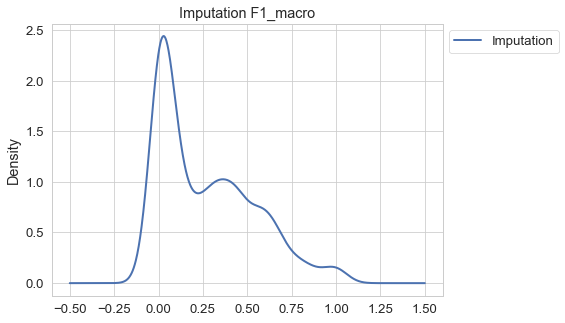

In [133]:
row_idx = results["metric"] == CLF_METRIC
results.loc[row_idx,["Imputation"]].plot(kind="kde", title=f"Imputation {CLF_METRIC}", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

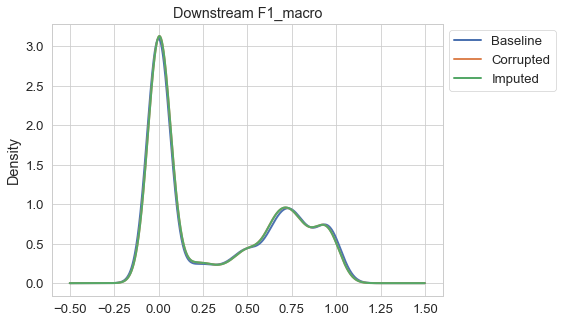

In [153]:
row_idx = results["metric"] == CLF_METRIC
results.loc[row_idx,["Baseline", "Corrupted", "Imputed"]].plot(kind="kde", title=f"Downstream {CLF_METRIC}", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

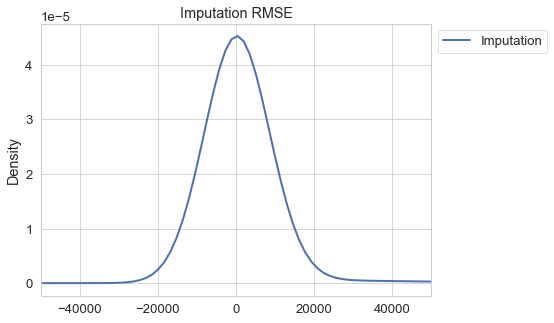

In [142]:
row_idx = results["metric"] == REG_METRIC
results.loc[row_idx,["Imputation"]].plot(kind="kde", title=f"Imputation {REG_METRIC}", figsize=(7,5), xlim=(-50000, 50000))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

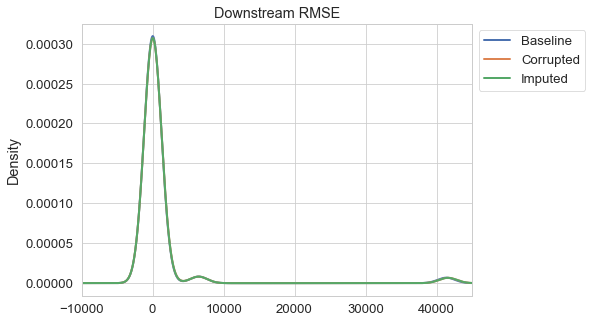

In [151]:
row_idx = results["metric"] == REG_METRIC
results.loc[row_idx,["Baseline", "Corrupted", "Imputed"]].plot(kind="kde", title=f"Downstream {REG_METRIC}", figsize=(7,5), xlim=(-10000, 45000))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

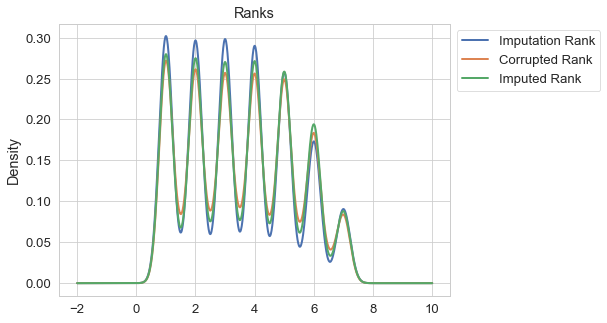

In [159]:
ranked_results[["Imputation Rank", "Corrupted Rank", "Imputed Rank"]].plot(kind="kde", title="Ranks", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

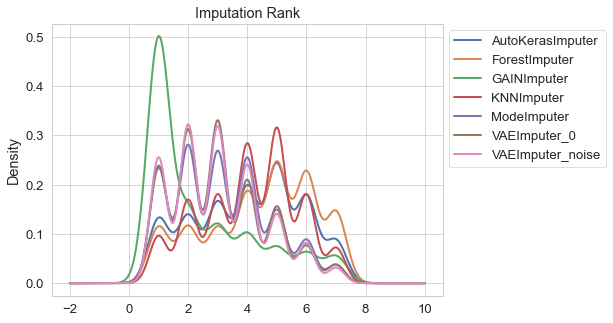

In [156]:
kde_data = ranked_results[["Imputer", "Imputation Rank"]]
kde_data = kde_data.pivot(columns="Imputer", values="Imputation Rank")

kde_data.plot(kind="kde", title="Imputation Rank", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

### Check if results are complete

The bars in the following plot should have the same height.

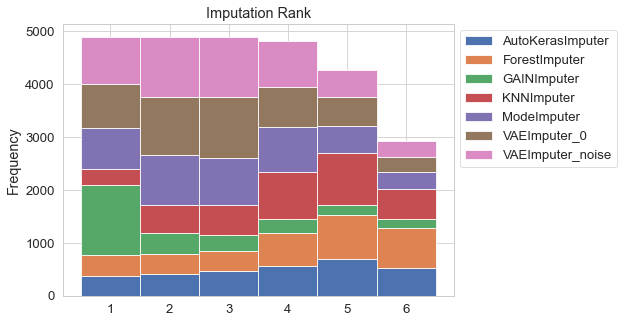

In [157]:
check_data = ranked_results[["Imputer", "Imputation Rank"]]
check_data = check_data.pivot(columns="Imputer", values="Imputation Rank")

check_data.plot(kind="hist", title="Imputation Rank", figsize=(7,5), stacked=True, bins=np.linspace(0.5, 6.5, 7))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

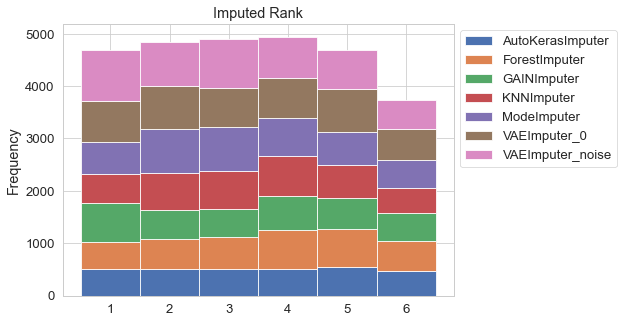

In [160]:
check_data = ranked_results[["Imputer", "Imputed Rank"]]
check_data = check_data.pivot(columns="Imputer", values="Imputed Rank")

check_data.plot(kind="hist", title="Imputed Rank", figsize=(7,5), stacked=True, bins=np.linspace(0.5, 6.5, 7))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

## Plotting Functions

In [130]:
def plot_metric_vs_missing_fraction(data, result_type, metric_names, y, ylabel, export_path, figure_name):
    row_idx = (data["result_type"] == result_type) & (data["metric"].isin(metric_names))
    plot_data = data.loc[row_idx]
    
    plt.figure(figsize=(10,7))
    ax = sns.lineplot(
        data=plot_data, 
        x="Missing Fraction", 
        y=y, 
        hue="Imputer", 
        style="Imputer",
        ci=66
    )
    ax.set(ylabel=ylabel)
    ax.set_xticks(sorted(results["Missing Fraction"].unique()))
    
    plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner 
    
    Path(export_path/result_type).mkdir(parents=True, exist_ok=True)    
    plt.savefig(export_path/result_type/f"{figure_name}.svg")

## Application Scenario 1 - Imputation Performance

In [105]:
IMPUTE_RESULT_TYPE = "impute_performance_mean"

IMPUTE_VAL_COL = "Imputation"

### 1.1) Categorical Columns (Classification)

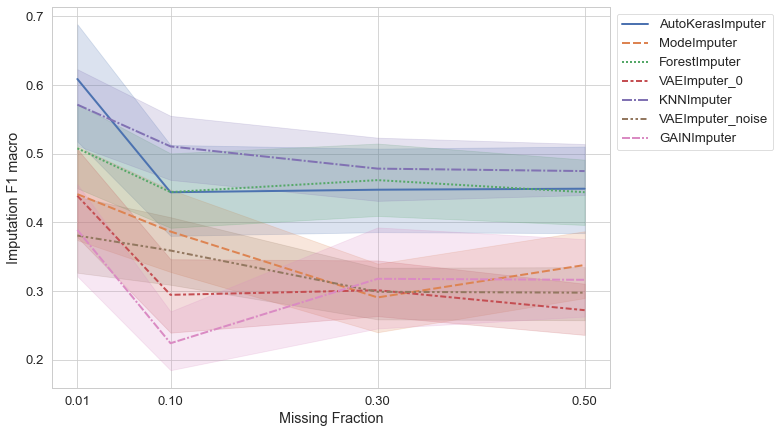

In [131]:
plot_metric_vs_missing_fraction(
    data = results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [CLF_METRIC], 
    y = IMPUTE_VAL_COL,
    ylabel = f"{IMPUTE_VAL_COL} {CLF_METRIC.replace('_', ' ')}",
    export_path = FIGURES_PATH,
    figure_name = "categorical"
)

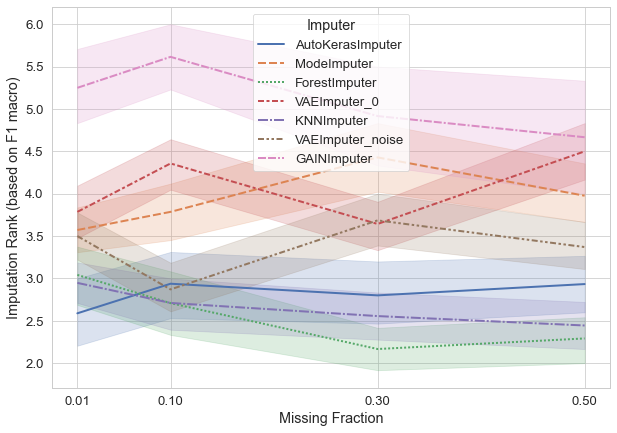

In [107]:
plot_metric_vs_missing_fraction(
    data = ranked_results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [CLF_METRIC], 
    y = "Imputation Rank",
    ylabel = f"Imputation Rank (based on {CLF_METRIC.replace('_', ' ')})",
    export_path = FIGURES_PATH,
    figure_name = "categorical_rank"
)

### 1.2) Numerical Columns (Regression)

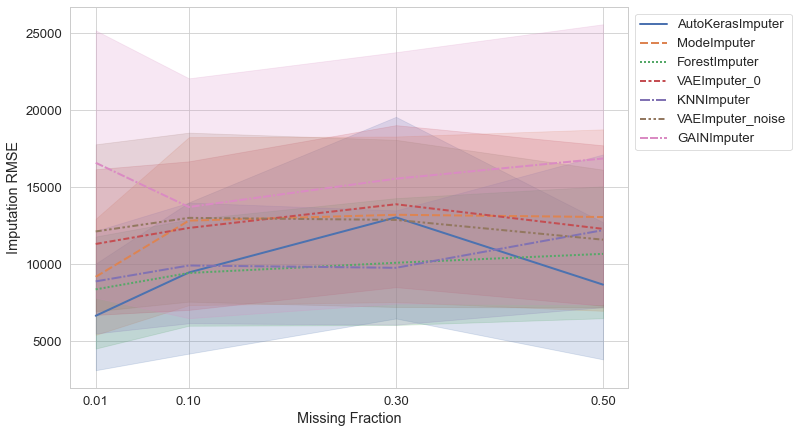

In [132]:
plot_metric_vs_missing_fraction(
    data = results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [REG_METRIC], 
    y = IMPUTE_VAL_COL,
    ylabel = f"{IMPUTE_VAL_COL} {REG_METRIC}",
    export_path = FIGURES_PATH,
    figure_name = "numerical"
)

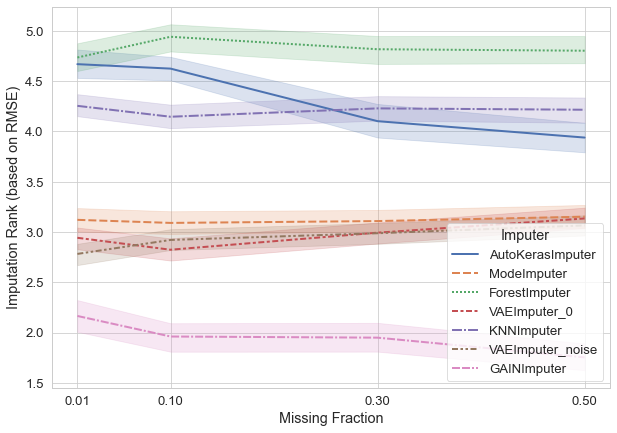

In [109]:
plot_metric_vs_missing_fraction(
    data = ranked_results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [REG_METRIC], 
    y = "Imputation Rank",
    ylabel = f"Imputation Rank (based on {REG_METRIC})",
    export_path = FIGURES_PATH,
    figure_name = "numerical_rank"
)

### 1.3) Heterogenous Columns (Classification and Regression Combined)

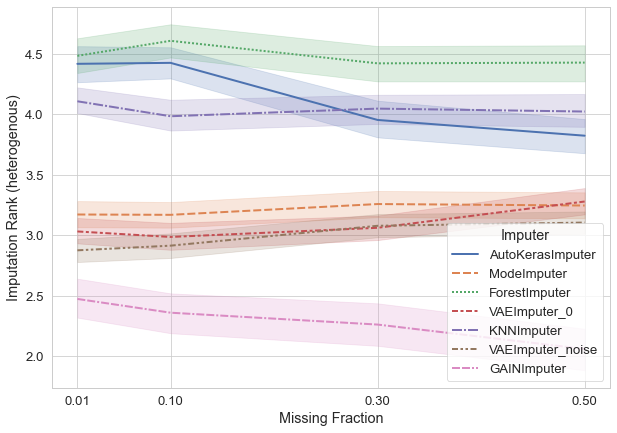

In [110]:
plot_metric_vs_missing_fraction(
    data = ranked_results, 
    result_type = IMPUTE_RESULT_TYPE,
    metric_names = [CLF_METRIC, REG_METRIC], 
    y = "Imputation Rank",
    ylabel = f"Imputation Rank (heterogenous)",
    export_path = FIGURES_PATH,
    figure_name = "heterogenous_rank"
)

### TODO: Do we need a weighted average?!

In [111]:
row_idx = (results["result_type"] == IMPUTE_RESULT_TYPE) & (results["metric"].isin([CLF_METRIC, REG_METRIC]))
check_data = results.loc[row_idx]
check_data.groupby(["metric"]).size()

metric
F1_macro     598
RMSE        4273
dtype: int64

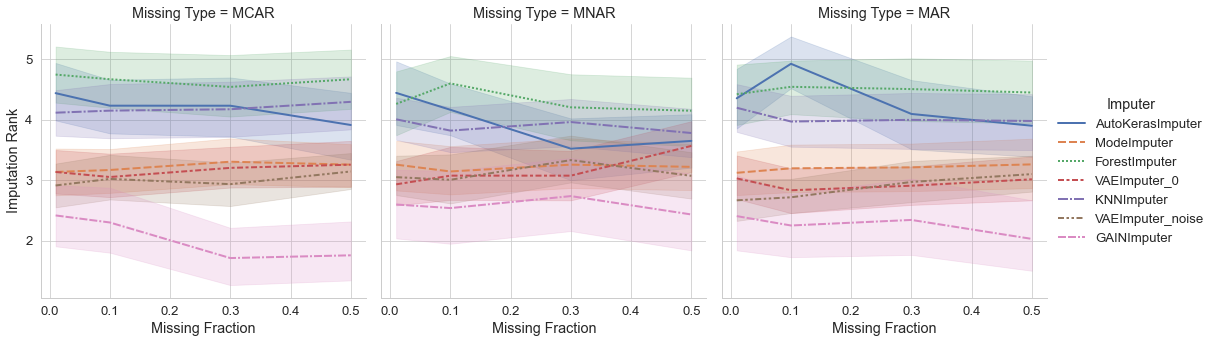

In [112]:
# TODO this needs to be changed

row_idx = (results["result_type"] == IMPUTE_RESULT_TYPE) & (results["metric"].isin([CLF_METRIC, REG_METRIC]))
plot_data = ranked_results[row_idx]

sns.relplot(
    data=plot_data, 
    x="Missing Fraction", 
    y="Imputation Rank", 
    hue="Imputer", 
    style="Imputer", 
    col="Missing Type",
    kind="line",
)
plt.gcf().subplots_adjust(bottom=0.15, left=0.05) # avoid x/ylabel cutoff in SVG export
plt.savefig(FIGURES_PATH/IMPUTE_RESULT_TYPE/"relplot.svg")

## Application Scenario 2 - Downstream Performance

In [113]:
DOWNSTREAM_RESULT_TYPE = "downstream_performance_mean"

Path(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE).mkdir(parents=True, exist_ok=True)

In [114]:
DOWNSTREAM_BASELINE_VAL_COL = "Baseline"
DOWNSTREAM_CORRUPTED_VAL_COL = "Corrupted"
DOWNSTREAM_IMPUTED_VAL_COL = "Imputed"

### 2.1) Categorical  Columns (Classification)

#### Evaluate `corrupted`

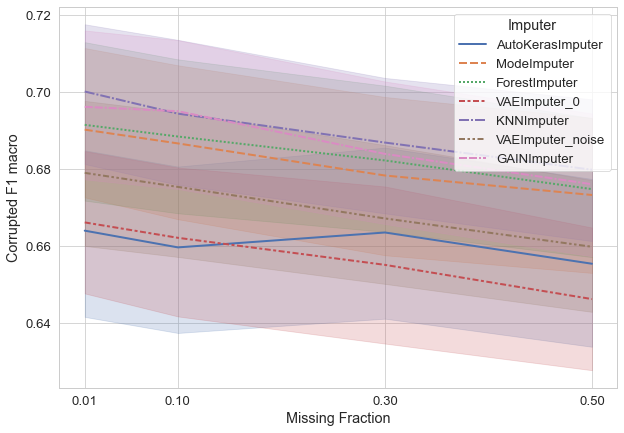

In [115]:
plot_metric_vs_missing_fraction(
    data = results, 
    result_type = DOWNSTREAM_RESULT_TYPE,
    metric_names = [CLF_METRIC], 
    y = DOWNSTREAM_CORRUPTED_VAL_COL,
    ylabel = f"{DOWNSTREAM_CORRUPTED_VAL_COL} {CLF_METRIC.replace('_', ' ')}",
    export_path = FIGURES_PATH,
    figure_name = "corrutped_categorical"
)

#### Evaluate `imputed`


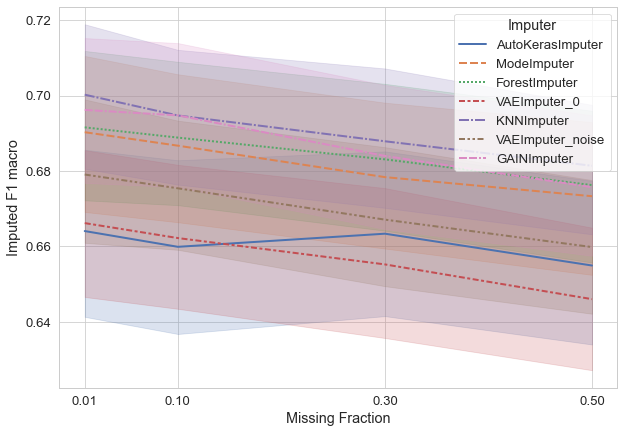

In [116]:
plot_metric_vs_missing_fraction(
    data = results, 
    result_type = DOWNSTREAM_RESULT_TYPE,
    metric_names = [CLF_METRIC], 
    y = DOWNSTREAM_IMPUTED_VAL_COL,
    ylabel = f"{DOWNSTREAM_IMPUTED_VAL_COL} {CLF_METRIC.replace('_', ' ')}",
    export_path = FIGURES_PATH,
    figure_name = "imputed_categorical"
)

### 2.2) Numerical Columns (Regression)

#### Evaluate `corrupted`

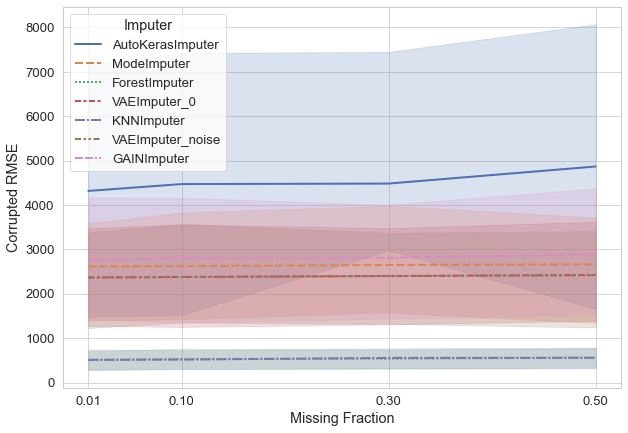

In [117]:
plot_metric_vs_missing_fraction(
    data = results, 
    result_type = DOWNSTREAM_RESULT_TYPE, 
    metric_names = [REG_METRIC], 
    y = DOWNSTREAM_CORRUPTED_VAL_COL,
    ylabel = f"{DOWNSTREAM_CORRUPTED_VAL_COL} {REG_METRIC}",
    export_path = FIGURES_PATH,
    figure_name = "corrupted_numerical"
)

#### Evaluate `imputed`

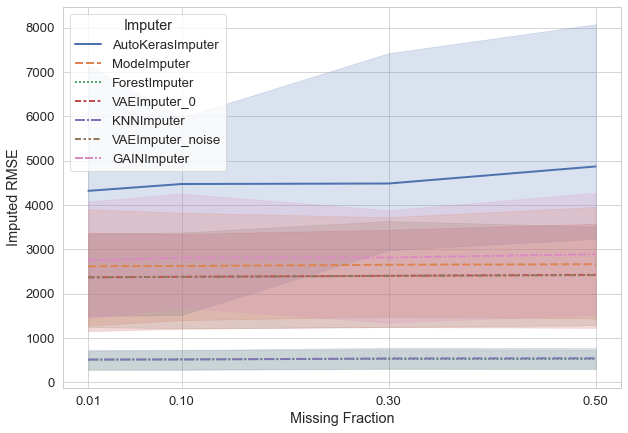

In [118]:
plot_metric_vs_missing_fraction(
    data = results, 
    result_type = DOWNSTREAM_RESULT_TYPE, 
    metric_names = [REG_METRIC], 
    y = DOWNSTREAM_IMPUTED_VAL_COL,
    ylabel = f"{DOWNSTREAM_IMPUTED_VAL_COL} {REG_METRIC}",
    export_path = FIGURES_PATH,
    figure_name = "imputed_numerical"
)

### 2.3) Heterogenous Columns (Classification and Regression Combined)

#### Evaluate `corrupted`

#### Evaluate `imputed`